# 1 Demo for the COCO-Text data API 

In this demo, we will learn how to load the COCO-Text data using the python API.

Let's first import the `coco_text` tool API package. 

In [1]:
import coco_text

Make sure that you have downloaded the annotation file from the website.

Once downloaded, you can import the annotations in the following way:

In [17]:
ct = coco_text.COCO_Text('cocotext.v2.json')

loading annotations into memory...
0:00:01.675332
creating index...
index created!


Now, lets use the API. First, the API offers some basic infos of the dataset.

In [19]:
ct.info()

### Select annotations and images based on filter criteria

Let's retrieve some images. We want to get a list of all image ids from the training set, where the image contains at least one text instance that is legilbe and is machine printed.

In [20]:
imgs = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible'),('class','machine printed')])
print(len(imgs))

13880


Let's now go on to the annotations. We want to get a list of all annotation ids from the validation set that are legible, machine printed and have an area between 0 and 200 pixels.

In [40]:
anns = ct.getAnnIds(imgIds=ct.val, 
                        catIds=[('legibility','legible'),('class','machine printed')], 
                        areaRng=[0,200])
# print(ct.loadAnns(annIds))
m = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
height = m["height"]
width = m["width"]
import numpy
from PIL import Image, ImageDraw
def coor_to_mask(coors, width, height):
    # coors is an array of [x1, y1, x2, y2, ...]
    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(coors, outline=1, fill=1)
    mask = numpy.array(img)
    return mask
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
print(coor_to_mask(anns[0]['mask'], width, height))
# print(coor_to_mask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# 2 Visualize COCOText Annotations

In order to visualize the COCO Text annotations, please make sure to download the COCO Images from the MSCOCO website: http://mscoco.org/dataset/#download 

After downloading the images, specify the path to the MSCOCO image data.

In [22]:
dataDir='.'
dataType='train2014'

Lets now import some useful tools to visualize the COCO images and annotations

In [23]:
%matplotlib inline
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

Using the API introduced above, lets select an image that has at least one instance of legible text.

In [24]:
# get all images containing at least one instance of legible text
imgIds = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible')])
# pick one at random
img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

We can now load the image

/train2014/COCO_train2014_000000505420.jpg


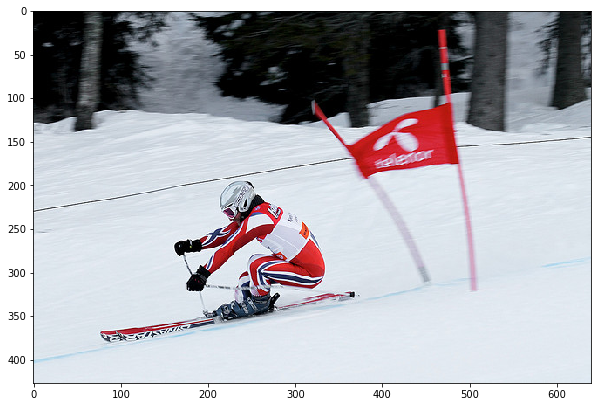

In [25]:
I = io.imread('%s/%s/%s'%(dataDir,dataType,img['file_name']))
print('/%s/%s'%(dataType,img['file_name']))
plt.figure()
plt.imshow(I)

Lastly, we can load and display the text annotations

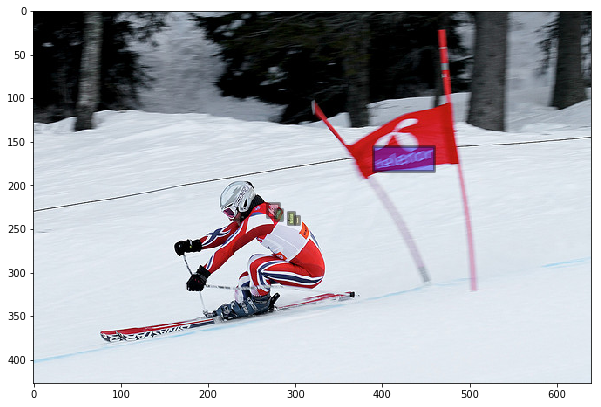

In [26]:
# load and display text annotations
plt.imshow(I)
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns)

# 3 Demo for the COCO-Text evaluation API

In this demo we will learn how to use the COCO-Text evaluation API to evaluate text detection and recognition results.

First, let's import the `coco_text_evaluation` API.  

In [29]:
import coco_evaluation

Next, we have to load our recognition results. For this we can use the `loadRes()` function from the `coco_text` tool.

The results have to be saved in the format explained on the website. The '`our_results.json`' file gives an example. Generally, the detections are saved in a json file and form a list of dictionaries like the following:

    [{"image_id": int,
      "bbox": [left, top, width, height],
      "utf8_string": string"},
      {}...]

Then, we can load the results like this:

In [30]:
our_results = ct.loadRes('our_results.json')

Loading and preparing results...     
DONE (t=0.00s)


If the results file contains annotations for images not in the current version of COCO-Text, the loader will notify
that some images are skipped and then ignore the respective annotations. This happens for example, if results for the test set are included in the same file.

### Detection results

Once the resutls are loaded, the evalution tool allows to compute the successful detections with the '`getDetections()`' function. The `detection_threshold` parameter defines how closely the bounding boxes need to overlap. The default value is an Intersection over Union (IoU) score of 0.5. 

In [31]:
our_detections = coco_evaluation.getDetections(ct, our_results, detection_threshold = 0.5)

The detection results comprise three lists: True Positives, False Positives and False Negatives.

In [32]:
print('True positives have a ground truth id and an evaluation id: ', our_detections['true_positives'][0])
print('False positives only have an evaluation id: ', our_detections['false_positives'][0])
print('True negatives only have a ground truth id: ', our_detections['false_negatives'][0])

True positives have a ground truth id and an evaluation id:  {'gt_id': 1148291, 'eval_id': 0}
False positives only have an evaluation id:  {'eval_id': 7}
True negatives only have a ground truth id:  {'gt_id': 1067513}


### End-to-end results

Let's look into the transcription performance now. For that we ue the '`evaluateTranscription()`' function. And provide our results and detections.

In [33]:
our_endToEnd_results = coco_evaluation.evaluateEndToEnd(ct, our_results, detection_threshold = 0.5)

Now we are ready to see the results. For that we can use the '`printDetailedResults()`' function. The last line can be used to create a table as shown in the paper.

In [34]:
coco_evaluation.printDetailedResults(ct,our_detections,our_endToEnd_results,'our approach')

our approach

Detection
Recall
legible & machine printed:  0.01
legible & handwritten:  0.00
legible overall:  0.01
illegible & machine printed:  0.00
illegible & handwritten:  0.00
illegible overall:  0.00
total recall:  0.0
Precision
total precision:  50.00
f-score
f-score localization:  0.01

Transcription
accuracy for exact matches:  0.00
accuracy for matches with edit distance<=1:  100.00

End-to-end
recall:  0.00 precision:  0.00
End-to-end f-score:  0

0.01 & 0.00 & 0.00 & 0.00 & 0.0 & 50.00 & 0.01 & 0.00 & 0.00 & 0.00 & 0
